In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

dataset_dir = "/content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

print("Train:", train_dir)
print("Val:", val_dir)
print("Test:", test_dir)


Train: /content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray/train
Val: /content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray/val
Test: /content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray/test


In [ ]:
!ls "$train_dir"
!ls "$val_dir"
!ls "$test_dir"


NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [ ]:
def count_images(path):
    total = 0
    for root, _, files in os.walk(path):
        total += len([f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return total

print("Train:", count_images(train_dir))
print("Val:", count_images(val_dir))
print("Test:", count_images(test_dir))


Train: 5216
Val: 16
Test: 624


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


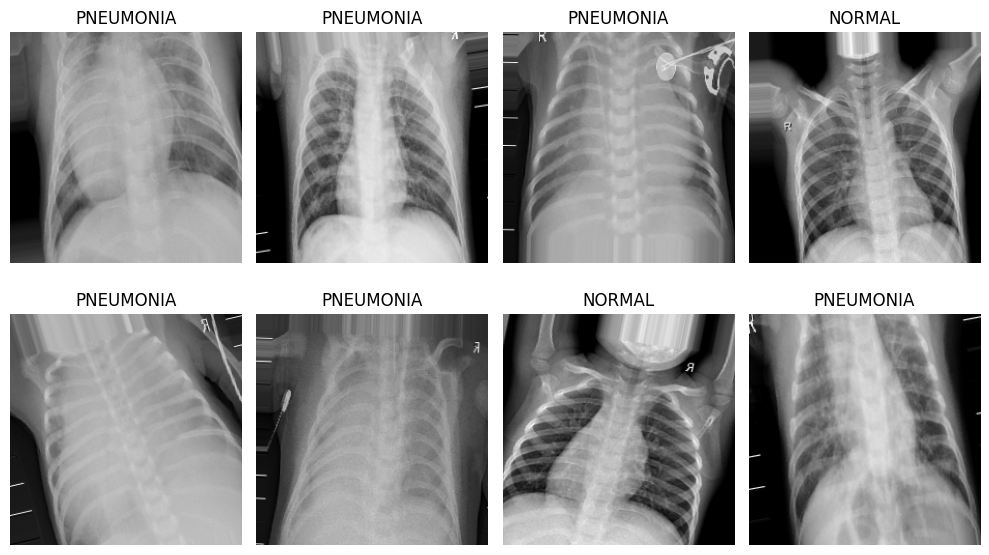

In [ ]:
# ✅ Import the required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# The training set is augmented (rotated, flipped, zoomed) to help the model generalize better.
# Validation and test sets are only normalized (no augmentation).
train_datagen = ImageDataGenerator(
    rescale=1./255,             # normalize pixel values (0–1)
    rotation_range=15,          # random rotation (±15°)
    width_shift_range=0.1,      # horizontal shift
    height_shift_range=0.1,     # vertical shift
    shear_range=0.1,            # shearing transformations
    zoom_range=0.1,             # zoom in/out
    horizontal_flip=True        # random horizontal flips
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# =============================================================
# STEP 2️⃣ : Create Directory Iterators
# =============================================================
# These automatically read images from the folder and apply transformations.
train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray/train",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray/val",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Datasets/chest_xray_dataset_fixed/chest_xray/test",
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# We'll grab one batch of 32 images and display a few with labels.
images, labels = next(train_gen)

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title("PNEUMONIA" if labels[i] else "NORMAL")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Sequential() → stack layers one after another
cnn_model = Sequential([

    # --- Convolution Block 1 ---
    # 32 filters → each learns small 3×3 patterns from the image.
    # ReLU adds non-linearity so it can learn complex patterns.
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),   # halves width/height → reduces computation

    # --- Convolution Block 2 ---
    # Doubled filters (64) → deeper patterns like lung textures.
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # --- Convolution Block 3 ---
    # Even more filters (128) → high-level features (infection regions).
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # --- Fully Connected Layers ---
    Flatten(),                      # 3-D feature maps → 1-D vector
  ;  Dense(128, activation='relu'),   # 128 neurons to learn global combinations
    'Dropout(0.5),                    # randomly drops 50 % neurons (prevents overfitting)

    # --- Output Layer ---
    Dense(1, activation='sigmoid')   # gives value 0→Normal, 1→Pneumonia
])


cnn_model.compile(
    optimizer='adam',                # adaptive learning optimizer
    loss='binary_crossentropy',      # suitable for 2-class problems
    metrics=['accuracy']             # track accuracy while training
)


cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# EarlyStopping → stop training if val_accuracy doesn't improve for 5 epochs
# ModelCheckpoint → save the model with the best validation accuracy
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/pneumonia_cnn_model.h5', save_best_only=True)
]

history = cnn_model.fit(
    train_gen,                   # training data
    validation_data=val_gen,     # validation data
    epochs=15,                   # you can increase later if needed
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7498 - loss: 0.5104 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1709s 10s/step - accuracy: 0.7501 - loss: 0.5098 - val_accuracy: 0.8125 - val_loss: 0.4350
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 787ms/step - accuracy: 0.8751 - loss: 0.2804 - val_accuracy: 0.8125 - val_loss: 0.5213
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.8905 - loss: 0.2498

163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 752ms/step - accuracy: 0.8905 - loss: 0.2498 - val_accuracy: 0.8125 - val_loss: 0.4097
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 743ms/step - accuracy: 0.9150 - loss: 0.2149 - val_accuracy: 0.8125 - val_loss: 0.5689
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 725ms/step - accuracy: 0.9258 - loss: 0.2074 - val_accuracy: 0.6250 - val_loss: 1.2475
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 740ms/step - accuracy: 0.9199 - loss: 0.2135 - val_accuracy: 0.7500 - val_loss: 0.7489
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 747ms/step - accuracy: 0.9315 - loss: 0.1878 - val_accuracy: 0.7500 - val_loss: 0.4195
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.9207 - loss: 0.2040

163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - accuracy: 0.9207 - loss: 0.2039 - val_accuracy: 0.8125 - val_loss: 0.3256
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 775ms/step - accuracy: 0.9380 - loss: 0.1741 - val_accuracy: 0.6875 - val_loss: 0.7353
Epoch 10/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 752ms/step - accuracy: 0.9464 - loss: 0.1451 - val_accuracy: 0.8125 - val_loss: 0.3341
Epoch 11/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 748ms/step - accuracy: 0.9433 - loss: 0.1512 - val_accuracy: 0.6875 - val_loss: 0.5677
Epoch 12/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 749ms/step - accuracy: 0.9522 - loss: 0.1390 - val_accuracy: 0.6875 - val_loss: 0.4789
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 741ms/step - accuracy: 0.9561 - loss: 0.1231 - val_accuracy: 0.8750 - val_loss: 0.4331


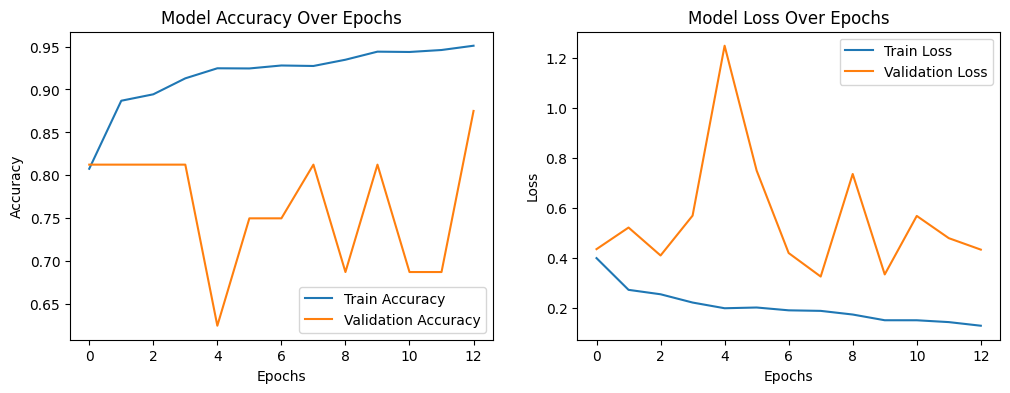

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 198s 10s/step

Classification Report:

              precision    recall  f1-score   support

      Normal       0.93      0.55      0.69       234
   Pneumonia       0.78      0.97      0.87       390

    accuracy                           0.81       624
   macro avg       0.85      0.76      0.78       624
weighted avg       0.84      0.81      0.80       624



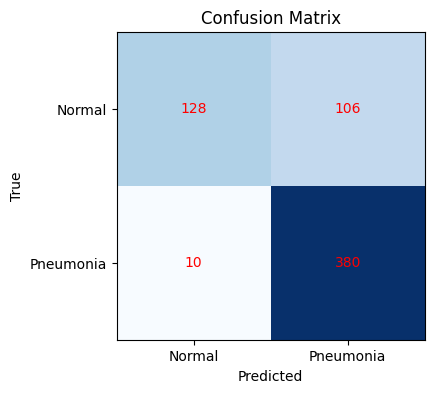

✅ Best model saved at: /content/drive/MyDrive/pneumonia_cnn_model.h5


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_preds = (cnn_model.predict(test_gen) > 0.5).astype("int32")

print("\nClassification Report:\n")
print(classification_report(test_gen.classes, test_preds, target_names=['Normal', 'Pneumonia']))


cm = confusion_matrix(test_gen.classes, test_preds)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], ['Normal','Pneumonia'])
plt.yticks([0,1], ['Normal','Pneumonia'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

plt.show()

print("✅ Best model saved at: /content/drive/MyDrive/pneumonia_cnn_model.h5")


In [ ]:
from google.colab import files
files.download('pneumonia_cnn_model.h5')


FileNotFoundError: Cannot find file: pneumonia_cnn_model.h5